In [0]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!git clone https://github.com/cloughurd/SimCLR.git
!cp -r SimCLR/* .

Cloning into 'SimCLR'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 590 (delta 28), reused 43 (delta 15), pack-reused 530
Receiving objects: 100% (590/590), 83.78 MiB | 30.16 MiB/s, done.
Resolving deltas: 100% (318/318), done.


In [0]:
import os
from classification_loaders.encodedcc import CompCars
data_root = '/content/gdrive/My Drive/Winter 2020/DL/Final/data/compCars'

In [0]:
label_dims = {
    'make': 163,
    'model': 1716,
    'type': 12,
    'door_number': 5
}

In [0]:
def accuracy(output, target):
  output = output.argmax(dim=1)
  acc = output.eq(target).sum()
  acc = acc / float(target.numel())
  return acc.item()

In [0]:
def train(embedder='cc', target='make', num_epochs=200, batch_size=64):
  dec = nn.Sequential(
      nn.Linear(2048, 200),
      nn.Linear(200, label_dims[target])
  )
  dec = dec.to('cuda')
  opt = optim.Adam(dec.parameters())
  sched = optim.lr_scheduler.MultiStepLR(opt, milestones=[
                                                int(num_epochs * 0.3),
                                                int(num_epochs * 0.5),
                                                int(num_epochs * 0.8)])
  obj = nn.CrossEntropyLoss()

  train_enc_file = os.path.join(data_root, f'compCars-{embedder}model-train_encodings.pt')
  val_enc_file = os.path.join(data_root, f'compCars-{embedder}model-valid_encodings.pt')
  train_loader = DataLoader(
      CompCars(data_root, train_enc_file, label_type=target), batch_size=batch_size, shuffle=True
  )
  val_loader = DataLoader(
      CompCars(data_root, val_enc_file, label_type=target, train=False), batch_size=batch_size
  )

  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  loop = tqdm(total=len(train_loader) * num_epochs, position=0, leave=True)
  for e in range(num_epochs):
    for x, y in train_loader:
      opt.zero_grad()
      x = x.cuda()
      y = y.cuda().squeeze(1)
      y_hat = dec(x)

      loss = obj(y_hat, y)
      loss.backward()
      opt.step()

      acc = accuracy(y_hat, y)
      loop.set_description(f'Epoch: {e}, Loss: {loss.item()}, Accuracy: {acc}')
      loop.update(1)

      train_loss.append(loss.item())
      train_acc.append(acc)
    sched.step()

    loss_builder = []
    acc_builder = []
    with torch.no_grad():
      dec.eval()

      for x, y_truth in val_loader:
        x = x.cuda()
        y_truth = y_truth.squeeze(1).cuda()
        y_hat = dec(x)

        total_loss = obj(y_hat, y_truth)
        acc = accuracy(y_hat, y_truth)

        loss_builder.append(total_loss.item())
        acc_builder.append(acc)

    dec.train()

    val_acc.append((len(train_acc), np.mean(acc_builder)))
    val_loss.append((len(train_loss), np.mean(loss_builder)))

  print(f'Final Train Acc: {train_acc[-1]}')
  print(f'Final Val Acc: {val_acc[-1]}')
  return {
      'train_loss': train_loss, 
      'train_acc': train_acc, 
      'val_loss': val_loss,
      'val_acc': val_acc
  }

In [0]:
def plot(results, title):
  train_loss = results['train_loss']
  train_acc = results['train_acc']
  val_loss = results['val_loss']
  val_acc = results['val_acc']

  l_idx, val_loss = zip(*val_loss)
  a_idx, val_acc = zip(*val_acc)

  plt.plot(train_loss)
  plt.plot(l_idx, val_loss)
  plt.xlabel('Step')
  plt.ylabel('Loss')
  plt.title(f'Loss: {title}')
  plt.ylim((0,6))
  plt.show()

  plt.plot(train_acc)
  plt.plot(a_idx, val_acc)
  plt.xlabel('Step')
  plt.ylabel('Accuracy')
  plt.title(f'Accuracy: {title}')
  plt.ylim((0,1))
  plt.show()

Epoch: 199, Loss: 2.7684812545776367, Accuracy: 0.3125: 100%|█████████▉| 50199/50200 [04:29<00:00, 227.85it/s] 

Final Train Acc: 0.3125
Final Val Acc: (50200, 0.26576102009186375)


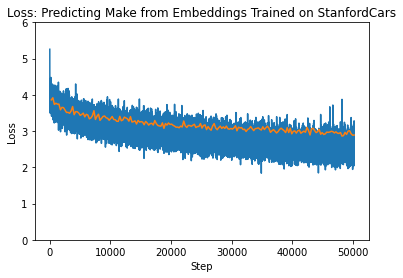

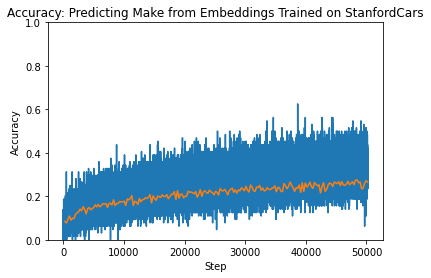

In [13]:
sc_make_results = train('sc')
plot(sc_make_results, 'Predicting Make from Embeddings Trained on StanfordCars')

Epoch: 199, Loss: 0.9535660147666931, Accuracy: 0.7419354915618896: 100%|█████████▉| 48999/49000 [07:05<00:00, 137.03it/s]

Final Train Acc: 0.7419354915618896
Final Val Acc: (49000, 0.5762421479612067)


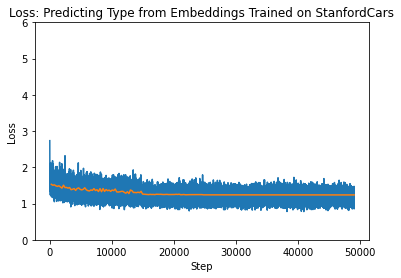

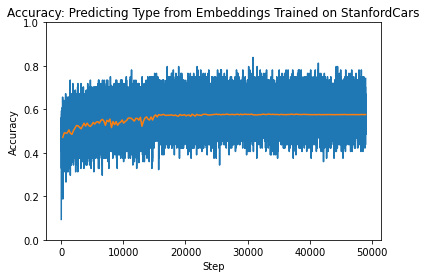

In [16]:
sc_type_results = train('sc', 'type')
plot(sc_type_results, 'Predicting Type from Embeddings Trained on StanfordCars')

Epoch: 199, Loss: 1.826170802116394, Accuracy: 0.5625: 100%|█████████▉| 50199/50200 [04:23<00:00, 230.90it/s]  

Final Train Acc: 0.5625
Final Val Acc: (50200, 0.33239108502355397)


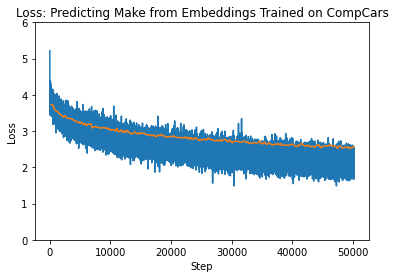

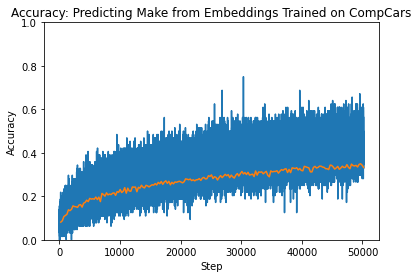

In [14]:
sc_make_results = train('cc')
plot(sc_make_results, 'Predicting Make from Embeddings Trained on CompCars')

Epoch: 199, Loss: 0.7701107859611511, Accuracy: 0.774193525314331: 100%|█████████▉| 48999/49000 [06:41<00:00, 139.09it/s]

Final Train Acc: 0.774193525314331
Final Val Acc: (49000, 0.6444371653753415)


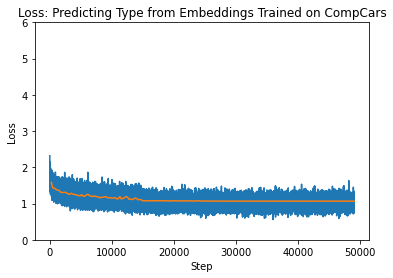

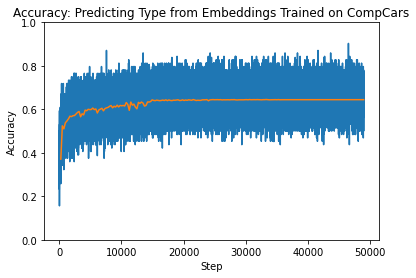

In [17]:
sc_make_results = train('cc', target='type')
plot(sc_make_results, 'Predicting Type from Embeddings Trained on CompCars')

Epoch: 199, Loss: 0.7833641767501831, Accuracy: 0.7096773982048035: 100%|█████████▉| 48999/49000 [04:02<00:00, 239.22it/s]

Final Train Acc: 0.7096773982048035
Final Val Acc: (49000, 0.7026522543215961)


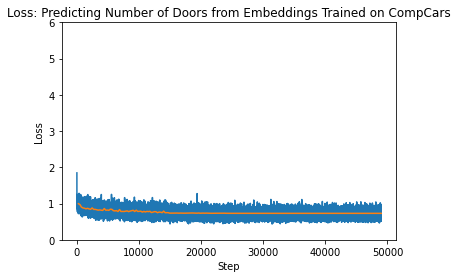

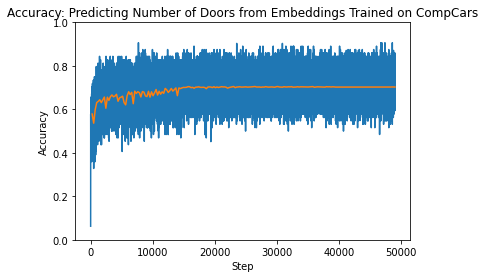

In [10]:
cc_door_results = train('cc', target='door_number')
plot(cc_door_results, 'Predicting Number of Doors from Embeddings Trained on CompCars')

Epoch: 199, Loss: 0.8025878071784973, Accuracy: 0.6774193048477173: 100%|█████████▉| 48999/49000 [04:30<00:00, 221.18it/s]

Final Train Acc: 0.6774193048477173
Final Val Acc: (49000, 0.6343155292826786)


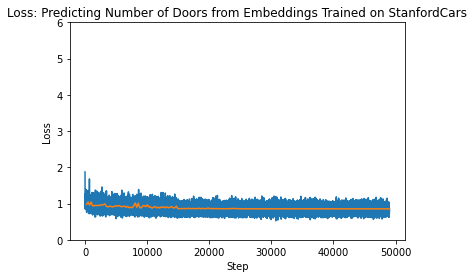

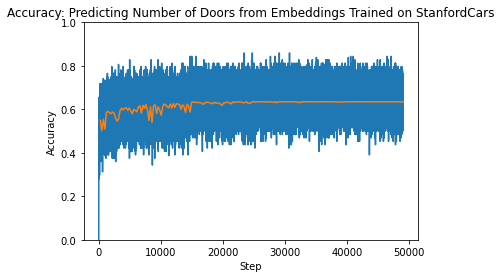

In [11]:
sc_door_results = train('sc', target='door_number')
plot(sc_door_results, 'Predicting Number of Doors from Embeddings Trained on StanfordCars')